# Unsupervised Learning on LendingClub data
Can Kmeans, MiniBatch Kmeans and MeanShift predict a good vs a bad loan?

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.cluster import KMeans, MiniBatchKMeans, MeanShift, SpectralClustering
from sklearn.decomposition import TruncatedSVD  # a form of PCA for NLP
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer, normalize, scale

from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

%matplotlib inline

In [2]:
#import warnings
# warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('lending_club_le.csv')

In [4]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
df.head()

,loan_amnt,installment,annual_inc,dti,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,...,emp_length,home_ownership,verification_status,pymnt_plan,purpose,title,addr_state,revol_util,initial_list_status,application_type
0,3000.0,93.10,52000.0,0.58,0.0,7.0,0.0,141.0,30.0,0.0,...,9,3,1,0,5,7,46,5,1,0
1,5000.0,166.03,55000.0,14.18,0.0,14.0,1.0,11449.0,24.0,0.0,...,1,2,0,0,8,10,10,334,1,0
2,20300.0,509.66,55000.0,26.63,0.0,10.0,0.0,17506.0,26.0,0.0,...,10,3,2,0,1,2,33,744,1,0
3,7000.0,232.44,40000.0,20.25,0.0,13.0,0.0,5004.0,29.0,0.0,...,10,1,2,0,3,6,42,355,1,0
4,10000.0,326.92,52320.0,12.87,1.0,6.0,1.0,1692.0,26.0,0.0,...,10,3,1,0,2,3,46,380,1,0


In [6]:
df.shape

(73318, 69)

In [7]:
df.good_loan_status.value_counts()

1    56725
0    16593
Name: good_loan_status, dtype: int64

In [8]:
56725/(16593+56725)

0.7736844976676942

---

In [9]:
y = df['good_loan_status']
X = df.drop(['good_loan_status'], axis=1)

In [10]:
#from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                    test_size=0.20,
#                                                    random_state=42)'''

'from sklearn.model_selection import train_test_split\nX_train, X_test, y_train, y_test = train_test_split(X, y,\n                                                    test_size=0.20, \n                                                    random_state=42)'

In [20]:
X.shape, y.shape

((73318, 68), (73318,))

# Kmeans vs MiniBatchKmeans analysis

How accurately will Kmeans cluster data into good and bad loan data?

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


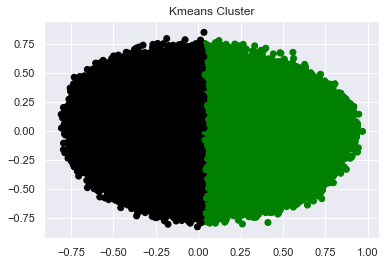

In [99]:
colormap = np.array(['green', 'black'])
X_norm = normalize(scale(X))
X_pca = PCA(2).fit_transform(X_norm)
y_pred = KMeans(n_clusters=2, random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.title('Kmeans Cluster')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colormap[y_pred])
plt.show()

In [100]:
# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

Comparing k-means clusters against the data:
good_loan_status     0      1
row_0                        
0                 6969  25136
1                 9624  31589


_PCA is used to reduce the data to 2 components because we are looking to see if Kmeans can predict a good loan_

_Looks like this model isn't doing very well. We're __correctly classifying 34,785 (9595+25190)__ cases, but __mis-classifying 38,533 (31535+6998)__ of the cases!_


_Let's look at MiniBatch to see if that would be better_

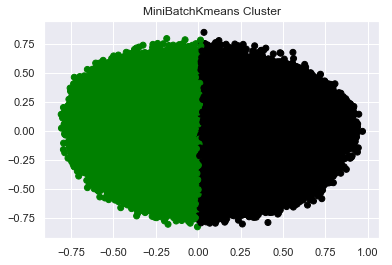

Comparing k-means and mini batch k-means solutions:
good_loan_status     0      1
row_0                        
0                 9071  30050
1                 7522  26675


In [101]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=2,
    batch_size=1000)
minibatchkmeans.fit(X_pca)

# Add the new predicted cluster memberships to the data frame.
predict_mini = minibatchkmeans.predict(X_pca)
# Plot the solution.
colormap = np.array(['green', 'black'])
plt.title('MiniBatchKmeans Cluster')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colormap[predict_mini])
plt.show()
# MiniBatch model.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y))

MiniBatch Kmeans is able to __classify 34038 (9856+24182)___ and __mis-classify 39280(6737+32543)__ which is about the same as Kmeans.

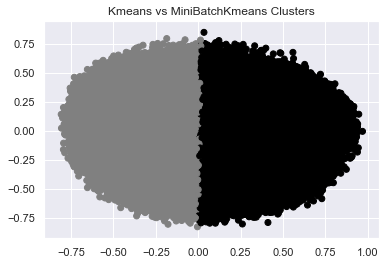

Comparing k-means and mini batch k-means solutions:
col_0      0      1
row_0              
0          0  39121
1      32105   2092


In [102]:
colormap = np.array(['grey', 'black'])
plt.title('Kmeans vs MiniBatchKmeans Clusters')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colormap[predict_mini])
plt.show()
# MiniBatch model.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(predict_mini, y_pred))

# Kmeans analysis

Without PCA how well will Kmeans predict good loans

In [28]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [29]:
kmeans.cluster_centers_

array([[1.92294607e+04, 5.58138040e+02, 1.24154399e+05, 1.96676746e+01,
        5.64993633e-01, 1.42445883e+01, 1.28342530e-01, 2.53639697e+04,
        3.10848896e+01, 1.43117459e+03, 1.24151104e-02, 1.27674024e+00,
        3.52016129e+00, 1.11269100e+00, 1.38414155e+01, 1.36598048e+00,
        2.85961375e+00, 7.98001289e+03, 5.45634550e+01, 5.95598249e+04,
        1.67200764e+00, 5.98015705e+00, 3.39304825e+04, 2.37693506e+04,
        4.70153969e+01, 1.37126486e+02, 1.97260346e+02, 1.35374576e+01,
        6.24050297e+00, 3.01644737e+00, 2.39373408e+01, 5.12308998e-01,
        3.85154924e+00, 5.68346774e+00, 5.58000849e+00, 8.77663413e+00,
        1.19936863e+01, 9.38778650e+00, 1.57974321e+01, 5.69699703e+00,
        1.42304754e+01, 0.00000000e+00, 0.00000000e+00, 6.48875212e-02,
        2.82327037e+00, 9.51244058e+01, 3.12320246e+01, 1.12584890e-01,
        1.57045840e-02, 4.57638254e+05, 9.11230465e+04, 3.98285176e+04,
        7.94401755e+04, 9.19340748e+00, 3.23539655e+00, 3.372771

In [30]:
def converter(cluster):
    if cluster == 1:
        return 1
    else:
        return 0

In [34]:
X['Cluster'] = df['good_loan_status'].apply(converter)

In [38]:
X.Cluster.value_counts()
print('The baseline is : 77.37%')

the baseline is : 77.37%


In [94]:
print(confusion_matrix(X['Cluster'], kmeans.labels_))
print(classification_report(X['Cluster'], kmeans.labels_))

[[ 3211 13382]
 [15641 41084]]
              precision    recall  f1-score   support

           0       0.17      0.19      0.18     16593
           1       0.75      0.72      0.74     56725

   micro avg       0.60      0.60      0.60     73318
   macro avg       0.46      0.46      0.46     73318
weighted avg       0.62      0.60      0.61     73318



_When using 2 cluster, Kmeans weighted average is 62%, it doesn't beat the baseline of 77%.  It was able to __classify 44295__ and __mis-classify 29023__ loans._

In [40]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(X['Cluster'], kmeans.labels_)

-0.029390858102939194

_I will take the top 5 features from the supervised learning to see if it can cluster good loans based on the attributes_

# MeanShift
_I will take the top 5 features from the supervised learning to see if it can cluster good loans based on the attributes_

In [41]:
df1 = pd.read_csv('lending_club_le.csv')
df1.drop('Unnamed: 0', axis=1, inplace=True)
df1.shape

(73318, 69)

In [78]:
top5Features = df1[['dti', 'max_bal_bc',
                    'months_since_last_credit_pull_d',
                    'mo_sin_old_rev_tl_op',
                    'sub_grade']]
#top5Features = top5Features.drop(['good_loan_status'], axis=1)

In [96]:
top5Features.head()

,dti,max_bal_bc,months_since_last_credit_pull_d,mo_sin_old_rev_tl_op,sub_grade
0,0.58,141.0,6.950820,242.0,3
1,14.18,4829.0,9.967213,199.0,9
2,26.63,8215.0,1.016393,111.0,15
3,20.25,3944.0,3.016393,132.0,9
4,12.87,1692.0,1.016393,48.0,8


In [80]:
others = df1[~df1.index.isin(['dti',
                              'max_bal_bc',
                              'months_since_last_credit_pull_d',
                              'mo_sin_old_rev_tl_op',
                              'sub_grade'])]

In [81]:
others.head()

,loan_amnt,installment,annual_inc,dti,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,...,emp_length,home_ownership,verification_status,pymnt_plan,purpose,title,addr_state,revol_util,initial_list_status,application_type
0,3000.0,93.10,52000.0,0.58,0.0,7.0,0.0,141.0,30.0,0.0,...,9,3,1,0,5,7,46,5,1,0
1,5000.0,166.03,55000.0,14.18,0.0,14.0,1.0,11449.0,24.0,0.0,...,1,2,0,0,8,10,10,334,1,0
2,20300.0,509.66,55000.0,26.63,0.0,10.0,0.0,17506.0,26.0,0.0,...,10,3,2,0,1,2,33,744,1,0
3,7000.0,232.44,40000.0,20.25,0.0,13.0,0.0,5004.0,29.0,0.0,...,10,1,2,0,3,6,42,355,1,0
4,10000.0,326.92,52320.0,12.87,1.0,6.0,1.0,1692.0,26.0,0.0,...,10,3,1,0,2,3,46,380,1,0


In [82]:
others.shape

(73318, 69)

In [83]:
bandwidth2 = estimate_bandwidth(others.drop('good_loan_status', axis=1),
                                quantile=0.2, n_samples=70)
# introduce the radius, also create bins to store the clusters.
ms = MeanShift(bandwidth2, bin_seeding=True)

In [84]:
ms.fit(others.drop('good_loan_status', axis=1))
msLabels = ms.labels_

In [85]:
msLabels

array([  0,   0,   0, ..., 142, 189,   0])

In [86]:
df1.head()

,loan_amnt,installment,annual_inc,dti,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,...,emp_length,home_ownership,verification_status,pymnt_plan,purpose,title,addr_state,revol_util,initial_list_status,application_type
0,3000.0,93.10,52000.0,0.58,0.0,7.0,0.0,141.0,30.0,0.0,...,9,3,1,0,5,7,46,5,1,0
1,5000.0,166.03,55000.0,14.18,0.0,14.0,1.0,11449.0,24.0,0.0,...,1,2,0,0,8,10,10,334,1,0
2,20300.0,509.66,55000.0,26.63,0.0,10.0,0.0,17506.0,26.0,0.0,...,10,3,2,0,1,2,33,744,1,0
3,7000.0,232.44,40000.0,20.25,0.0,13.0,0.0,5004.0,29.0,0.0,...,10,1,2,0,3,6,42,355,1,0
4,10000.0,326.92,52320.0,12.87,1.0,6.0,1.0,1692.0,26.0,0.0,...,10,3,1,0,2,3,46,380,1,0


In [87]:
others.head()

,loan_amnt,installment,annual_inc,dti,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,...,emp_length,home_ownership,verification_status,pymnt_plan,purpose,title,addr_state,revol_util,initial_list_status,application_type
0,3000.0,93.10,52000.0,0.58,0.0,7.0,0.0,141.0,30.0,0.0,...,9,3,1,0,5,7,46,5,1,0
1,5000.0,166.03,55000.0,14.18,0.0,14.0,1.0,11449.0,24.0,0.0,...,1,2,0,0,8,10,10,334,1,0
2,20300.0,509.66,55000.0,26.63,0.0,10.0,0.0,17506.0,26.0,0.0,...,10,3,2,0,1,2,33,744,1,0
3,7000.0,232.44,40000.0,20.25,0.0,13.0,0.0,5004.0,29.0,0.0,...,10,1,2,0,3,6,42,355,1,0
4,10000.0,326.92,52320.0,12.87,1.0,6.0,1.0,1692.0,26.0,0.0,...,10,3,1,0,2,3,46,380,1,0


In [88]:
dict = {}
for var in zip(others, msLabels):
    dict[var[0]] = var[1]

In [89]:
dict

{'loan_amnt': 0,
 'installment': 0,
 'annual_inc': 0,
 'dti': 0,
 'inq_last_6mths': 0,
 'open_acc': 0,
 'pub_rec': 0,
 'revol_bal': 0,
 'total_acc': 0,
 'out_prncp': 0,
 'collections_12_mths_ex_med': 142,
 'open_acc_6m': 0,
 'open_act_il': 224,
 'open_il_12m': 0,
 'mths_since_rcnt_il': 0,
 'open_rv_12m': 0,
 'open_rv_24m': 0,
 'max_bal_bc': 0,
 'all_util': 0,
 'total_rev_hi_lim': 0,
 'inq_fi': 48,
 'acc_open_past_24mths': 0,
 'avg_cur_bal': 0,
 'bc_open_to_buy': 0,
 'bc_util': 0,
 'mo_sin_old_il_acct': 0,
 'mo_sin_old_rev_tl_op': 0,
 'mo_sin_rcnt_rev_tl_op': 0,
 'mo_sin_rcnt_tl': 0,
 'mort_acc': 0,
 'mths_since_recent_bc': 0,
 'num_accts_ever_120_pd': 0,
 'num_actv_bc_tl': 0,
 'num_actv_rev_tl': 0,
 'num_bc_sats': 0,
 'num_bc_tl': 0,
 'num_il_tl': 0,
 'num_op_rev_tl': 0,
 'num_rev_accts': 0,
 'num_rev_tl_bal_gt_0': 0,
 'num_sats': 0,
 'num_tl_120dpd_2m': 142,
 'num_tl_30dpd': 0,
 'num_tl_90g_dpd_24m': 142,
 'num_tl_op_past_12m': 0,
 'pct_tl_nvr_dlq': 0,
 'percent_bc_gt_75': 224,
 'pub_

In [90]:
clusters = pd.DataFrame(list(dict.items()), columns=[
                        'Features', 'Cluster_MeanShift'])

In [113]:
clusters['Cluster_MeanShift'].value_counts()

0      55
142     5
224     4
62      1
48      1
38      1
24      1
5       1
Name: Cluster_MeanShift, dtype: int64

_MeanShift was able to make 8 clusters.  Most of the the loans are in cluster 0_

In [91]:
clusters.tail(20)

,Features,Cluster_MeanShift
49,tot_hi_cred_lim,0
50,total_bal_ex_mort,142
51,total_bc_limit,0
52,total_il_high_credit_limit,0
53,months_since_issue_d,0
54,months_since_last_credit_pull_d,0
55,good_loan_status,0
56,term,0
57,grade,0
58,sub_grade,142


# How many cluster does Kmeans actually find?  The elbow method is used to find the best k. 

In [117]:
# function to determine K
def kClusters(X):
    plt.rcParams['figure.figsize'] = [9, 5]

    squaredSums = []
    K = range(1, 45)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel = kmeanModel.fit(X)
        squaredSums.append(kmeanModel.inertia_)

    # Plot the elbow
    plt.plot(K, squaredSums, 'bx-')
    plt.xlabel('k')
    plt.ylabel('squaredSums')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [128]:
# Find the clusters and plot them
sns.set(style="darkgrid")
def clusterModels(X, y, k):
    fig, ax = plt.subplots(111, figsize=(9, 9))
    plt.rcParams.update({'font.size': 15})
    models = []
    names = []
    plt_num = []

    # Normalize the data.
    svd = TruncatedSVD(50)
    lsa = make_pipeline(svd, Normalizer(copy=False))

    # Run SVD on the training data, then project the training data.
    X_lsa = lsa.fit_transform(X)

    models.append((0, 'KMeans', KMeans(n_clusters=k, init='k-means++')))

    for plt_num, name, model in models:
        names.append(name)
        model.fit(X_lsa)
        labels = model.labels_
        colormap=['green','black']
        ax[plt_num].set_title(name)
        ax[plt_num].scatter(X_lsa[:, 0], X_lsa[:, 1], c=colormap[labels])
        print(name)
        print(pd.crosstab(y, labels), '\n\n')

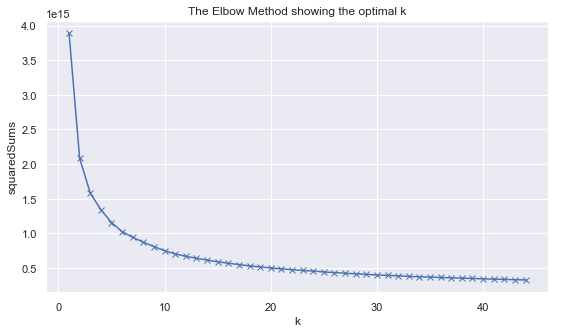

In [114]:
# find k
kClusters(X)

_The elbow method predicts 7 clusters_

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


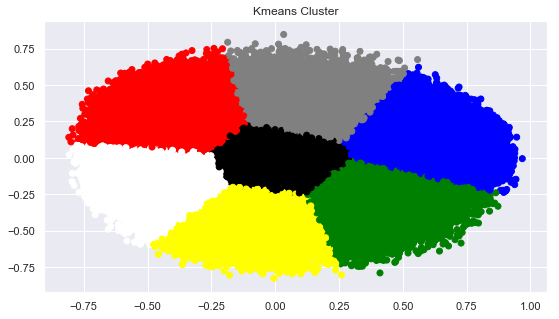

In [130]:
colormap = np.array(['green', 'black', 'red', 'yellow', 'blue', 'grey','white'])
X_norm = normalize(scale(X))
X_pca = PCA(2).fit_transform(X_norm)
y_pred = KMeans(n_clusters=7, init='k-means++',random_state=42).fit_predict(X_pca)

# Plot the solution.
plt.title('Kmeans Cluster')
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colormap[y_pred])
plt.show()